<a href="https://colab.research.google.com/github/aworklab/everydayPython/blob/main/ex_20220903.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 오늘의 목표
* customer analysis
* iterator

In [7]:
import pandas as pd 
import numpy as np 
import plotnine as gg 
from plotnine import aes, ggplot
from datetime import datetime, date, time, timezone, timedelta 
import re
import os 

from functools import reduce 
from collections import Counter, defaultdict, ChainMap
from itertools import product, groupby

# customer analysis

In [8]:
os.listdir()

['.config',
 'KPMG_VI_New_raw_data_update_final.csv',
 'ecommerce-data.csv',
 'KPMG_VI_New_raw_data_update_final.xlsx',
 'online_retail_II.xlsx',
 'test.csv',
 'sample_data']

In [9]:
df = pd.read_excel('KPMG_VI_New_raw_data_update_final.xlsx', sheet_name = 'Transactions')
df.head()

,Note: The data and information in this document is reflective of a hypothetical situation and client. This document is to be used for KPMG Virtual Internship purposes only.,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
1,1,2,2950,2017-02-25 00:00:00,False,Approved,Solex,Standard,medium,medium,71.49,53.62,41245
2,2,3,3120,2017-05-21 00:00:00,True,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,41701
3,3,37,402,2017-10-16 00:00:00,False,Approved,OHM Cycles,Standard,low,medium,1793.43,248.82,36361
4,4,88,3135,2017-08-31 00:00:00,False,Approved,Norco Bicycles,Standard,medium,medium,1198.46,381.1,36145


In [10]:
df.columns = df.iloc[0]
df.drop([0], inplace = True)
df.head()

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
1,1,2,2950,2017-02-25 00:00:00,False,Approved,Solex,Standard,medium,medium,71.49,53.62,41245
2,2,3,3120,2017-05-21 00:00:00,True,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,41701
3,3,37,402,2017-10-16 00:00:00,False,Approved,OHM Cycles,Standard,low,medium,1793.43,248.82,36361
4,4,88,3135,2017-08-31 00:00:00,False,Approved,Norco Bicycles,Standard,medium,medium,1198.46,381.1,36145
5,5,78,787,2017-10-01 00:00:00,True,Approved,Giant Bicycles,Standard,medium,large,1765.3,709.48,42226


In [11]:
df = df[df.order_status == 'Approved']

In [12]:
df.transaction_date = df.transaction_date.to_numpy().astype('datetime64[ns]')
df['date'] = df.transaction_date.to_numpy().astype('datetime64[D]')
df['month'] = df.transaction_date.to_numpy().astype('datetime64[M]')
df = df[['customer_id', 'date', 'month', 'list_price']].rename(columns = {'customer_id':'id', 'list_price':'rev'})
df = df.groupby(['id','date','month'])['rev'].sum().reset_index()
df.head()

,id,date,month,rev
0,1,2017-01-05,2017-01-01,360.4
1,1,2017-02-21,2017-02-01,71.49
2,1,2017-03-27,2017-03-01,688.63
3,1,2017-03-29,2017-03-01,1274.93
4,1,2017-04-06,2017-04-01,1577.53


In [16]:
list_npu = df.groupby(['id'])['date'].min().reset_index().rename(columns = {'date':'npu_date'}).reindex(['id','npu_date'], axis = 1)
df_ = pd.merge(df, list_npu, 'left', 'id')
df_['days'] = (df_['date'] - df_['npu_date']).dt.days
df_['month'] = df_['month'].astype(str)
cnt = df_.groupby(['month', 'days'])['id'].count().reset_index().rename(columns = {'id':'pu'})
cnt['ratio'] = cnt.groupby(['month'])['pu'].apply(lambda x : round(x/x.max()*100,2))
cnt = pd.melt(cnt, id_vars = ['month','days'], var_name = 'type')
cnt.head()

,month,days,type,value
0,2017-01-01,0,pu,1347.0
1,2017-01-01,1,pu,17.0
2,2017-01-01,2,pu,17.0
3,2017-01-01,3,pu,19.0
4,2017-01-01,4,pu,19.0


/usr/local/lib/python3.7/dist-packages/plotnine/facets/facet.py:393: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


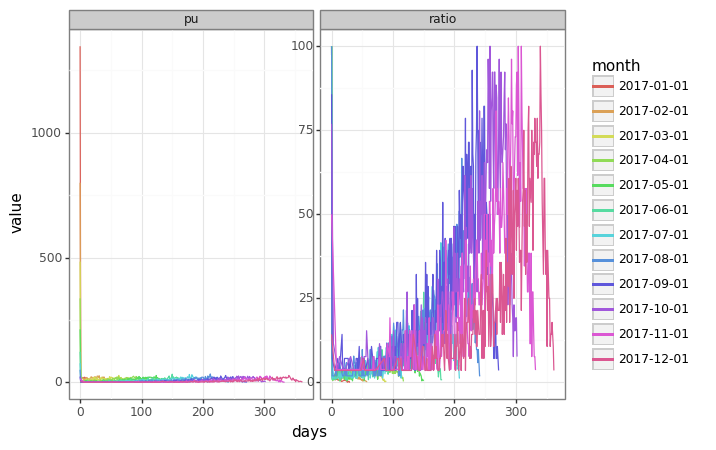

<ggplot: (8738042825309)>

In [17]:
(
    ggplot(cnt, aes('days', 'value', color = 'month')) +
    gg.geom_line() +
    gg.facet_wrap('~type', scales = 'free_y') + 
    gg.theme_bw()
)

# iterator

In [18]:
mat = [list('ABC'), list('DEF'), list('GHI')]
[(r, c, letters) for r, rows in enumerate(mat) for c, letters in enumerate(rows)]

[(0, 0, 'A'),
 (0, 1, 'B'),
 (0, 2, 'C'),
 (1, 0, 'D'),
 (1, 1, 'E'),
 (1, 2, 'F'),
 (2, 0, 'G'),
 (2, 1, 'H'),
 (2, 2, 'I')]

In [19]:
x, y, z = [10, 1], [1, 5], [1, 1]
for a, b, c in product(x,y,z) :
  if a + b + c >= 10 :
    print(a, b, c)

10 1 1
10 1 1
10 5 1
10 5 1


In [27]:
a = np.random.choice(list('abcdefghiklmopqr'), 1000, replace =  True)

In [28]:
b = defaultdict(int)
for x in a : 
  b[x] += 1
b

defaultdict(int,
            {'p': 73,
             'm': 57,
             'o': 67,
             'd': 71,
             'f': 59,
             'b': 53,
             'g': 66,
             'a': 77,
             'e': 61,
             'i': 72,
             'k': 57,
             'h': 51,
             'r': 65,
             'l': 51,
             'c': 55,
             'q': 65})

In [29]:
users = [{'mail': 'gregorythomas@gmail.com', 'name': 'Brett Holland', 'sex': 'M', 'age': 73},
 {'mail': 'hintoncynthia@hotmail.com', 'name': 'Madison Martinez', 'sex': 'F', 'age': 29},
 {'mail': 'wwagner@gmail.com', 'name': 'Michael Jenkins', 'sex': 'M', 'age': 51},
 {'mail': 'daniel79@gmail.com', 'name': 'Karen Rodriguez', 'sex': 'F', 'age': 32},
 {'mail': 'ujackson@gmail.com', 'name': 'Amber Rhodes', 'sex': 'F', 'age': 42}]
users

[{'mail': 'gregorythomas@gmail.com',
  'name': 'Brett Holland',
  'sex': 'M',
  'age': 73},
 {'mail': 'hintoncynthia@hotmail.com',
  'name': 'Madison Martinez',
  'sex': 'F',
  'age': 29},
 {'mail': 'wwagner@gmail.com',
  'name': 'Michael Jenkins',
  'sex': 'M',
  'age': 51},
 {'mail': 'daniel79@gmail.com',
  'name': 'Karen Rodriguez',
  'sex': 'F',
  'age': 32},
 {'mail': 'ujackson@gmail.com', 'name': 'Amber Rhodes', 'sex': 'F', 'age': 42}]

In [30]:
{key : eval(f'reduce(lambda acc, cur : acc + [cur["{key}"]], users, [])') for key in list(users[0].keys())}

{'mail': ['gregorythomas@gmail.com',
  'hintoncynthia@hotmail.com',
  'wwagner@gmail.com',
  'daniel79@gmail.com',
  'ujackson@gmail.com'],
 'name': ['Brett Holland',
  'Madison Martinez',
  'Michael Jenkins',
  'Karen Rodriguez',
  'Amber Rhodes'],
 'sex': ['M', 'F', 'M', 'F', 'F'],
 'age': [73, 29, 51, 32, 42]}

In [36]:
def add_arthor_with_name(name) :
  def add_arthor(func) :
    def wrapper(*args, **kwargs) :
      return name + '\n' + func(*args, **kwargs)
    return wrapper 
  return add_arthor

def add_arthor(func) :
  def wrapper(*args, **kwargs) :
    return 'park' + '\n' + func(*args, **kwargs)
  return wrapper

@add_arthor_with_name('kim')
def get_title(title) :
  return title

@add_arthor
def get_title2(t1, t2) :
  return t1 + ' ' + t2

In [37]:
print(get_title('아무 것도 난 몰랐잖아'))
print('-' * 10)
print(get_title2('너를 힘들게 했다는 게', '그런 것도 몰랐다는 게'))



kim
아무 것도 난 몰랐잖아
----------
park
너를 힘들게 했다는 게 그런 것도 몰랐다는 게
